# Título:
Diseño, Implementación y Evaluación de una Red Neuronal MLP para la Clasificación de Rostros

----

# Descripción:
En este hackathon, cada equipo desarrollarán un modelo de red neuronal de tipo Perceptrón Multicapa (MLP) utilizando PyTorch para clasificar una base de datos de imágenes de rostros. La base de datos consta de 2,410 imágenes, cada imagen está representada como un vector de  dimensión de 32256. Las imágenes corresponden a 38 personas diferentes, donde cada persona tiene múltiples fotografías. El objetivo principal es explorar diferentes configuraciones del modelo ajustando el número de neuronas en una capa oculta y utilizando distintas funciones de activación. A través de estas pruebas, los estudiantes analizarán el impacto de los hiperparámetros en el rendimiento del modelo, implementarán modificaciones en el código base provisto y presentarán una evaluación cuantitativa de los resultados.

----

# Objetivos:
## General:

Diseñar, implementar y evaluar una red neuronal MLP en PyTorch para la clasificación de imágenes de rostros.
## Específicos:
- Convertir y preparar los datos de imágenes en un formato adecuado para el entrenamiento del modelo.
- Implementar una red neuronal MLP con una sola capa oculta y explorar el impacto del número de neuronas en el rendimiento del modelo.
- Experimentar con diferentes funciones de activación, como ReLU, Sigmoid y Tanh, para observar sus efectos en la clasificación.
- Implementar y completar el código base provisto, asegurando que sea funcional y eficiente.
- Entrenar y evaluar múltiples configuraciones de la red neuronal utilizando métricas como accuracy, recall, precision y F1 score.
- Comparar los resultados de las distintas configuraciones y determinar cuál ofrece el mejor desempeño.
- Presentar los resultados en tablas y gráficas, explicando las conclusiones obtenidas.

## Base de Datos:

Link: [Aquí](https://drive.google.com/file/d/1X8-AJiG0_qW08rx5l8u1Vs3cmx5W8ETj/view?usp=sharing)


**Para aprender, debemos entrenar nuestra propia red neuronal. No dependas de herramientas como ChatGPT o sus variantes. Entrena tu cerebro, equivócate, identifica los errores y aprende de ellos, tal como lo haría una red neuronal MLP gigante.**

----

Mucha suerte y divierntanse aprendiendo. 😊😊😊

# 1. Librerías Necesarias

In [6]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from itertools import product
import numpy as np
from sklearn.decomposition import PCA
import scipy.io

In [7]:
# Detectar la GPU
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Usando {device}")

Usando cpu


# 2. Cargando datos de Archivo

La función load_data carga todas las imágenes de un archivo .m.
No se preocupe por eso, se hará de forma transparente para usted.

In [9]:
path = '/Users/elvisrojasmonguia/Documents/Python courses/UTEC/Hackatones/allFaces.mat'


In [10]:
def Load_data(file):
  faces_m_format = scipy.io.loadmat(path)
  faces = faces_m_format['faces']
  m = int(faces_m_format['m'])
  n = int(faces_m_format['n'])
  nfaces = np.ndarray.flatten(faces_m_format['nfaces'])
  y = np.zeros((faces.shape[1],))
  j = 0
  classes = list(range(len(nfaces)))
  for i in nfaces:
    y[j:j+i] = classes.pop(0)
    j = j + i
  print("Total dataset size:")
  print(f"n_samples: {faces.shape[1]}")
  print(f"n_features: {m*n}")
  print(f"n_classes: {len(nfaces)}")
  return faces, y, m, n, len(nfaces)

X,Y,m,n, n_classes = Load_data('allFaces.mat')



Total dataset size:
n_samples: 2410
n_features: 32256
n_classes: 38


/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_19705/354861965.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(faces_m_format['m'])
/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_19705/354861965.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(faces_m_format['n'])


In [11]:

num_categorias_unicas = np.unique(Y).size
print("Número de categorías únicas en Y:", num_categorias_unicas)

Número de categorías únicas en Y: 38


In [12]:
n_classes

38

## Funciones Utilitarias.
La función Plot_Face se ha implementado para que pueda ver una imagen de su base de datos.

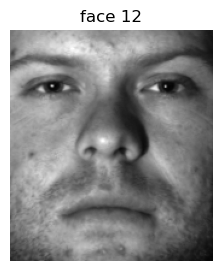

(32256, 2410)

In [14]:
def Plot_Face(image_vec, i,title):
  fig1 = plt.figure(figsize=(10, 3))
  image = image_vec.reshape((m,n))
  img = plt.imshow(image.T)
  img.set_cmap('gray')
  plt.title(title  + str(i))
  plt.axis('off')
  plt.show()


#dibuja una imagen
number_image = 12
image_vec = X.T[number_image]
Plot_Face(image_vec,number_image,'face ')
X.shape

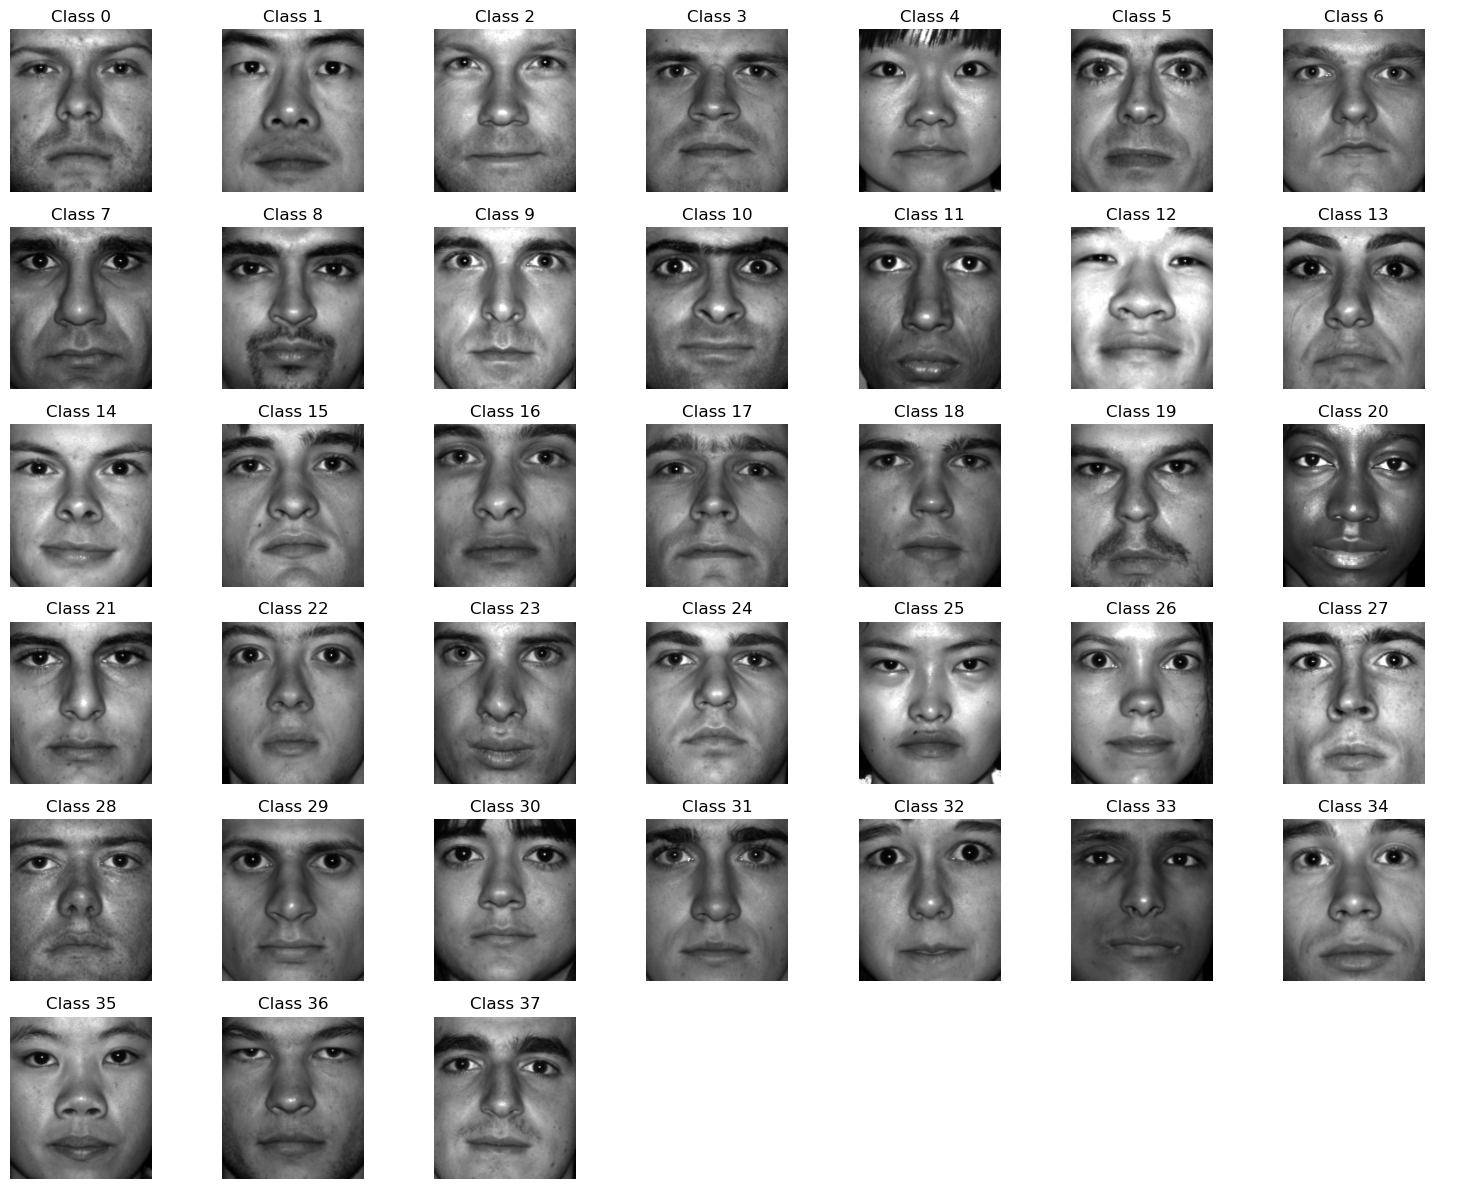

In [115]:
# Dibujar los 38 tipos de rostro
def Plot_All_Classes(X, Y, m, n, n_classes):
    fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(15, 12))
    axes = axes.flatten()
    
    for class_label in range(n_classes):
        # Encontrar el primer índice de la clase
        idx = np.where(Y == class_label)[0][0]
        image_vec = X[:, idx]  # Obtener la imagen correspondiente
        image = image_vec.reshape((m, n))  # Redimensionar la imagen

        # Dibujar en el sublote correspondiente
        ax = axes[class_label]
        ax.imshow(image.T, cmap='gray')
        ax.set_title(f"Class {class_label}")
        ax.axis('off')

    # Eliminar subplots extra
    for i in range(n_classes, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
Plot_All_Classes(X, Y, m, n, n_classes)


# 3. Reducción de la dimensionalidad

Completa el código para que sea funcional y permita reducir los datos, asegurando que se conserve el 95% de la varianza explicada.

In [16]:
pca           = PCA(n_components=0.95) #, random_state=42

#print(pca.explained_variance_)

X_pca  = pca.fit_transform(X.T)


In [17]:
print(X.T.shape) 
print(X_pca.shape)
### el tamano de las features de los datos originales vs los datos escalados por pca

(2410, 32256)
(2410, 62)


# 4. Separación de datos en train y test.
Complete el código usando la libreria train_test_split

1.  Divide los datos en conjuntos de entrenamiento y prueba utilizando train_test_split con un 25% para prueba.
2.  Recuerda que los datos a dividir son X_pca y Y.
3. Convierte los datos a tensores para que PyTorch pueda procesarlos correctamente.
4. Crear los dataloader para entrerar y testear el modelo. Se da un ejemplo.


In [19]:
# Escriba su código aquí para separar la data

from sklearn.model_selection import train_test_split

# Supongamos que tienes X_pca y Y ya definidos
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y,  test_size=0.25, random_state=42)


In [20]:
 # Imprimir las dimensiones de los conjuntos de datos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de Y_train:", Y_train.shape)
print("Dimensiones de Y_test:", Y_test.shape)

Dimensiones de X_train: (1807, 62)
Dimensiones de X_test: (603, 62)
Dimensiones de Y_train: (1807,)
Dimensiones de Y_test: (603,)


In [21]:
# Convierte tus datos a tensores.
# A continuación, te doy un ejemplo para X_test y Y_test.

x_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(Y_train, dtype=torch.long)


x_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(Y_test, dtype=torch.long)


In [22]:
# Crear TensorDataset y DataLoader. 
#Te pongo un ejemplo para el test


batch_size = 16
#para train 
dataset_train     = TensorDataset(x_train_t, y_train_t)
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


#para test
dataset_test = TensorDataset(x_test_t, y_test_t)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# 5. Modelo

Crea tu modelo MLP utilizando una  capa. Puedes experimentar con el número de neuronas en esa capa y las funciones de activación.

In [24]:
print(f"numero de clase de la target {n}"  )

numero de clase de la target 192


In [25]:
# cambiar el tipo de funcion de activacion de capas ocultas (hidden) y capas de salida. 

class Modelo_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Modelo_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
       
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  
 

# 6. Configuración de Parámetros
Configura los parámetros de tu modelo

In [27]:
# Parámetros del modelo
input_size   = X_pca.shape[1]
hidden_sizes = 128
output_size  = n_classes
epochs       = 100

### LLamamos , inicializamos el modelo NN
model     = Modelo_MLP(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# 7. Entrenamiento.
Completar el código que falta para que la función se ejecute correctamente.

In [29]:
# Función para entrenar el modelo
def train(model, criterion, optimizer, data_loader, epochs, device, print_ephocs=True):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        ## impresion del estado
        if print_ephocs:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")
            
        

In [30]:
train(model, criterion, optimizer, data_loader_train, epochs, device, print_ephocs = True)

Epoch 1/100, Loss: 197.4936
Epoch 2/100, Loss: 37.5717
Epoch 3/100, Loss: 17.6046
Epoch 4/100, Loss: 9.8265
Epoch 5/100, Loss: 8.4402
Epoch 6/100, Loss: 5.9036
Epoch 7/100, Loss: 4.3212
Epoch 8/100, Loss: 3.7192
Epoch 9/100, Loss: 2.2211
Epoch 10/100, Loss: 3.1315
Epoch 11/100, Loss: 2.4418
Epoch 12/100, Loss: 2.3252
Epoch 13/100, Loss: 1.7426
Epoch 14/100, Loss: 1.3897
Epoch 15/100, Loss: 2.3485
Epoch 16/100, Loss: 1.5108
Epoch 17/100, Loss: 1.7502
Epoch 18/100, Loss: 1.7446
Epoch 19/100, Loss: 1.9509
Epoch 20/100, Loss: 1.8216
Epoch 21/100, Loss: 1.3978
Epoch 22/100, Loss: 1.2082
Epoch 23/100, Loss: 1.4670
Epoch 24/100, Loss: 0.8118
Epoch 25/100, Loss: 0.9114
Epoch 26/100, Loss: 1.2375
Epoch 27/100, Loss: 1.4865
Epoch 28/100, Loss: 1.2896
Epoch 29/100, Loss: 1.0275
Epoch 30/100, Loss: 1.5173
Epoch 31/100, Loss: 1.0560
Epoch 32/100, Loss: 1.1971
Epoch 33/100, Loss: 1.0544
Epoch 34/100, Loss: 1.0512
Epoch 35/100, Loss: 0.6370
Epoch 36/100, Loss: 0.5184
Epoch 37/100, Loss: 0.3415
Epoch 

# 8. Testing
Completa el código necesario para evaluar tu modelo.
Se solicita que ajustes algunos hiperparámetros para crear al menos 3 modelos diferentes y mostrar sus resultados en una tabla.

In [32]:
# Evaluación del modelo
def evaluate_model(model, data_loader, criterion, device):
 
    model.eval()
    total_loss = 0.0
    y_pred = [];  y_real = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            output = model(x_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()

            # Convert predictions to class indices
            predictions = torch.argmax(output, dim=1).cpu().numpy()
            labels      = y_batch.cpu().numpy()

            # Store predictions and true labels
            y_pred.extend(predictions)
            y_real.extend(labels)

    # Convert lists to numpy arrays for metric calculation
    y_pred = torch.tensor(y_pred).numpy()
    y_real = torch.tensor(y_real).numpy()

    # Calculate metrics
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='weighted')
    recall = recall_score(y_real, y_pred, average='weighted')
    f1 = f1_score(y_real, y_pred, average='weighted')

    return { "loss": total_loss / len(data_loader), "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1 }

In [33]:
metrics = evaluate_model(model, data_loader_test, criterion, device)
print(metrics)

print(f"\n\n\nEl accuracy del modelo es {metrics['accuracy']}")

{'loss': 7.659520740045321, 'accuracy': 0.9203980099502488, 'precision': 0.9306257065953168, 'recall': 0.9203980099502488, 'f1': 0.9210760061934371}



El accuracy del modelo es 0.9203980099502488


# 9. Ejecutando y evaluando el modelo
- Si el código anterior es correcto, el siguiente fragmento debería ejecutarse sin problemas.
- El entrenamiento del modelo puede tardar entre 5 y 10 minutos, por lo que se recomienda tener paciencia.
- Sugerencia: cada miembro del equipo puede probar configuraciones diferentes del modelo y, posteriormente, reunir los resultados en una tabla única para evaluar cuál ofrece el mejor desempeño.


In [35]:
# Modelo con capas ocultas configurables y capa de salida explícita
class Modelo_MLP_settings(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_function, output_activation=None):
        super(Modelo_MLP_settings, self).__init__()
        layers = []
        prev_size = input_size

        # Crear capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation_function())
            prev_size = hidden_size
        
        # Capa de salida
        layers.append(nn.Linear(prev_size, output_size))
        
        # Agregar función de activación en la capa de salida (si está definida)
        if output_activation:
            layers.append(output_activation())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

## Con una capa oculta

In [37]:
# Crear combinaciones de parámetros para el Grid Search
hidden_layer_configs = [[128], [256], [512], [1024], [2048]]  # Solo una capa oculta
activation_functions = [nn.ReLU, nn.Tanh, nn.Sigmoid]  # Funciones de activación ocultas
output_activations   = [None, nn.Softmax]               # Función de activación en la capa de salida
epochs_list          = [50, 80, 150, 200, 250]                    # Número de épocas

# Crear combinaciones de parámetros
grid_search = list(product(hidden_layer_configs, activation_functions, output_activations, epochs_list))


total_models = len(grid_search)
print(f"EL numero total de modelos es {total_models}")

EL numero total de modelos es 150


In [38]:
 
# DataFrame para almacenar resultados
results_1capa_list = []


for i, (hidden_sizes, activation_func, output_activation, epochs) in enumerate(grid_search, start=1):
    # Initialize model, optimizer, and loss function
    print(f"\n\n\n\nModel #{i} de un total de {total_models}\n hidden_sizes={hidden_sizes}:, "
          f"activation function={activation_func.__name__}, "
          f"output activation function={output_activation.__name__ if output_activation else 'Linear'}, "
          f"epochs={epochs}")

    
    model = Modelo_MLP_settings(
        input_size=X_pca.shape[1],
        hidden_sizes=hidden_sizes,  # Solo una capa oculta
        output_size=n_classes,  # Capa de salida tiene n_classes neuronas
        activation_function=activation_func,
        output_activation=output_activation
    )
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss requiere que Softmax no se aplique antes
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenar modelo
    train(model, criterion, optimizer, data_loader_train, epochs, device, False)

    # Evaluar modelo
    metrics = evaluate_model(model, data_loader_test, criterion, device)
    print(f"El accuracy de este modelo es : {metrics["accuracy"]:.2f}")
    
    # Guardar resultados
    results_1capa_list.append({
        "Neuronas Hidden": ', '.join(map(str, hidden_sizes)),
        "Tipo de Función de Activación": activation_func.__name__,
        "Función Activación Salida": output_activation.__name__ if output_activation else "Lineal",
        "Número de Épocas": epochs,
        "Accuracy": metrics["accuracy"],
        "Recall": metrics["recall"],
        "Precision": metrics["precision"],
        "F1_Score": metrics["f1"]
    })






Model #1 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.90




Model #2 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.92




Model #3 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.91




Model #4 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.92




Model #5 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.93




Model #6 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.05




Model #7 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #8 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #9 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #10 de un total de 150
 hidden_sizes=[128]:, activation function=ReLU, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es : 0.05




Model #11 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.79




Model #12 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.77




Model #13 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.78




Model #14 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.78




Model #15 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.78




Model #16 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.75




Model #17 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.80




Model #18 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.74




Model #19 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.76




Model #20 de un total de 150
 hidden_sizes=[128]:, activation function=Tanh, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.76




Model #21 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.85




Model #22 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.88




Model #23 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.87




Model #24 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.88




Model #25 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.87




Model #26 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.75




Model #27 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.75




Model #28 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Softmax, epochs=150
El accuracy de este modelo es : 0.84




Model #29 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.85




Model #30 de un total de 150
 hidden_sizes=[128]:, activation function=Sigmoid, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.85




Model #31 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.91




Model #32 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.93




Model #33 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.93




Model #34 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.93




Model #35 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.93




Model #36 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #37 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #38 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #39 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #40 de un total de 150
 hidden_sizes=[256]:, activation function=ReLU, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es : 0.04




Model #41 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.84




Model #42 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.80




Model #43 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.81




Model #44 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.81




Model #45 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.82




Model #46 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.82




Model #47 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.80




Model #48 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.80




Model #49 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.81




Model #50 de un total de 150
 hidden_sizes=[256]:, activation function=Tanh, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.79




Model #51 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.88




Model #52 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.90




Model #53 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.89




Model #54 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.87




Model #55 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.87




Model #56 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.80




Model #57 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Softmax, epochs=80
El accuracy de este modelo es : 0.87




Model #58 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.87




Model #59 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.87




Model #60 de un total de 150
 hidden_sizes=[256]:, activation function=Sigmoid, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.89




Model #61 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.91




Model #62 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.94




Model #63 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.94




Model #64 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.93




Model #65 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.93




Model #66 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #67 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #68 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #69 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #70 de un total de 150
 hidden_sizes=[512]:, activation function=ReLU, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es : 0.03




Model #71 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.85




Model #72 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.82




Model #73 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.82




Model #74 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.84




Model #75 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.81




Model #76 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.85




Model #77 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.86




Model #78 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #79 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #80 de un total de 150
 hidden_sizes=[512]:, activation function=Tanh, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.80




Model #81 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.89




Model #82 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.90




Model #83 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.88




Model #84 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.89




Model #85 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.87




Model #86 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.80




Model #87 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.84




Model #88 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Softmax, epochs=150
El accuracy de este modelo es : 0.88




Model #89 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.87




Model #90 de un total de 150
 hidden_sizes=[512]:, activation function=Sigmoid, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.88




Model #91 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.94




Model #92 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.93




Model #93 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.92




Model #94 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.94




Model #95 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.93




Model #96 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #97 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #98 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #99 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #100 de un total de 150
 hidden_sizes=[1024]:, activation function=ReLU, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es : 0.04




Model #101 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.84




Model #102 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.85




Model #103 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.84




Model #104 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.85




Model #105 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.84




Model #106 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.84




Model #107 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.85




Model #108 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.84




Model #109 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #110 de un total de 150
 hidden_sizes=[1024]:, activation function=Tanh, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.82




Model #111 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.88




Model #112 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.87




Model #113 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.90




Model #114 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.88




Model #115 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.89




Model #116 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Softmax

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #117 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Softmax, epochs=80
El accuracy de este modelo es : 0.88




Model #118 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.87




Model #119 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.88




Model #120 de un total de 150
 hidden_sizes=[1024]:, activation function=Sigmoid, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.88




Model #121 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.93




Model #122 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.93




Model #123 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.92




Model #124 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.94




Model #125 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.94




Model #126 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #127 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #128 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.03




Model #129 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.02




Model #130 de un total de 150
 hidden_sizes=[2048]:, activation function=ReLU, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es : 0.03




Model #131 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.84




Model #132 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.76




Model #133 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.84




Model #134 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.85




Model #135 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.87




Model #136 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Softmax, epochs=50


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #137 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #138 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.83




Model #139 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.86




Model #140 de un total de 150
 hidden_sizes=[2048]:, activation function=Tanh, output activation function=Softmax, epochs=250


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.84




Model #141 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.88




Model #142 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.88




Model #143 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.87




Model #144 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Linear, epochs=200
El accuracy de este modelo es : 0.88




Model #145 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Linear, epochs=250
El accuracy de este modelo es : 0.87




Model #146 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Softmax

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.68




Model #147 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Softmax, epochs=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.81




Model #148 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Softmax, epochs=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.82




Model #149 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Softmax, epochs=200


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


El accuracy de este modelo es : 0.84




Model #150 de un total de 150
 hidden_sizes=[2048]:, activation function=Sigmoid, output activation function=Softmax, epochs=250
El accuracy de este modelo es : 0.83


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [113]:
# Crear DataFrame con los resultados
results_1capa_df = pd.DataFrame(results_1capa_list).sort_values("Accuracy", ascending=False).round(3)
results_1capa_df.head(5)

,Neuronas Hidden,Tipo de Función de Activación,Función Activación Salida,Número de Épocas,Accuracy,Recall,Precision,F1_Score
62,512,ReLU,Lineal,150,0.942,0.942,0.947,0.942
124,2048,ReLU,Lineal,250,0.939,0.939,0.944,0.939
123,2048,ReLU,Lineal,200,0.939,0.939,0.943,0.938
61,512,ReLU,Lineal,80,0.937,0.937,0.942,0.937
90,1024,ReLU,Lineal,50,0.937,0.937,0.942,0.937


In [40]:
## CNN

## Con dos capas ocultas

In [42]:
# Configuración de hiperparámetros para Grid Search
hidden_layer_configs = [[128, 64], [256, 128], [512, 256]]  # Al menos dos capas ocultas
activation_functions = [nn.ReLU, nn.Tanh, nn.Sigmoid]  # Funciones de activación ocultas
output_activations   = [None]  # Función de activación en la capa de salida
epochs_list          = [50, 80, 150]  # Épocas

# Crear combinaciones de parámetros
grid_search = list(product(hidden_layer_configs, activation_functions, output_activations, epochs_list))
total_models = len(grid_search)
print(f"EL numero total de modelos es {total_models}")

EL numero total de modelos es 27


In [43]:
# DataFrame para almacenar resultados
results_2capas_list = []

# Loop de entrenamiento y evaluación para cada combinación de hiperparámetros
for i, (hidden_sizes, activation_func, output_activation, epochs) in enumerate(grid_search, start=1):
    # Initialize model, optimizer, and loss function
    print(f"\n\n\n\nModel #{i} de un total de {total_models}\n hidden_sizes={hidden_sizes}:, "
          f"activation function={activation_func.__name__}, "
          f"output activation function={output_activation.__name__ if output_activation else 'Linear'}, "
          f"epochs={epochs}")

 
    # Inicializar modelo, optimizador y función de pérdida
    model = Modelo_MLP_settings(
        input_size          = X_pca.shape[1],
        hidden_sizes        = hidden_sizes,
        output_size         = n_classes,  # Capa de salida tiene n_classes neuronas
        activation_function = activation_func,
        output_activation   = output_activation
    )
    
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss requiere que Softmax no se aplique antes
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenar modelo
    train(model, criterion, optimizer, data_loader_train, epochs, device, False)

    # Evaluar modelo
    metrics = evaluate_model(model, data_loader_test, criterion, device)

    print(f"El accuracy de este modelo es : {metrics["accuracy"]:.2f}")
   
    # Guardar resultados
    results_2capas_list.append({
        "Neuronas Hidden": ', '.join(map(str, hidden_sizes)),
        "Tipo de Función de Activación": activation_func.__name__,
        "Función Activación Salida": output_activation.__name__ if output_activation else "Lineal",
        "Número de Épocas": epochs,
        "Accuracy": metrics["accuracy"],
        "Recall": metrics["recall"],
        "Precision": metrics["precision"],
        "F1_Score": metrics["f1"]
    })
 





Model #1 de un total de 27
 hidden_sizes=[128, 64]:, activation function=ReLU, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.76




Model #2 de un total de 27
 hidden_sizes=[128, 64]:, activation function=ReLU, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.78




Model #3 de un total de 27
 hidden_sizes=[128, 64]:, activation function=ReLU, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.81




Model #4 de un total de 27
 hidden_sizes=[128, 64]:, activation function=Tanh, output activation function=Linear, epochs=50
El accuracy de este modelo es : 0.78




Model #5 de un total de 27
 hidden_sizes=[128, 64]:, activation function=Tanh, output activation function=Linear, epochs=80
El accuracy de este modelo es : 0.75




Model #6 de un total de 27
 hidden_sizes=[128, 64]:, activation function=Tanh, output activation function=Linear, epochs=150
El accuracy de este modelo es : 0.75




Mode

In [44]:
### la primera relu, la segunda  sigmoid. mejor 

In [107]:
# Crear DataFrame con los resultados
results_2capas_df = pd.DataFrame(results_2capas_list).sort_values("Accuracy", ascending=False).round(3)
results_2capas_df.head(5)

,Neuronas Hidden,Tipo de Función de Activación,Función Activación Salida,Número de Épocas,Accuracy,Recall,Precision,F1_Score
25,"512, 256",Sigmoid,Lineal,80,0.904,0.904,0.913,0.904
24,"512, 256",Sigmoid,Lineal,50,0.896,0.896,0.906,0.896
26,"512, 256",Sigmoid,Lineal,150,0.887,0.887,0.902,0.889
17,"256, 128",Sigmoid,Lineal,150,0.874,0.874,0.884,0.874
7,"128, 64",Sigmoid,Lineal,80,0.871,0.871,0.882,0.871


## Con dos capas ocultas: La primera siempre es Relu

In [47]:

# Clase con funciones de activación configurables para cada capa
class Modelo_MLP_settings(nn.Module):
    def __init__(self, input_size, hidden_sizes, second_activation, output_size, output_activation=None):
        super(Modelo_MLP_settings, self).__init__()
        layers = []

        # Primera capa oculta con ReLU
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())  # Siempre ReLU en la primera capa

        # Segunda capa oculta con activación configurable
        layers.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
        layers.append(second_activation())  # Activación configurable (Tanh, Sigmoid, o ReLU)

        # Capa de salida
        layers.append(nn.Linear(hidden_sizes[1], output_size))

        # Agregar función de activación en la capa de salida (si está definida)
        if output_activation:
            layers.append(output_activation())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [48]:
# Configuración de hiperparámetros para Grid Search
hidden_layer_configs = [[128, 64], [256, 128], [512, 256]]  # Al menos dos capas ocultas
second_layer_activations = [nn.Tanh, nn.Sigmoid, nn.ReLU]  # Activaciones para la segunda capa
output_activations = [None]  # Salida lineal por defecto
epochs_list = [50, 80, 150]  # Épocas

# Crear combinaciones de parámetros
grid_search = list(product(hidden_layer_configs, second_layer_activations, output_activations, epochs_list))
total_models = len(grid_search)
print(f"El número total de modelos es {total_models}")


El número total de modelos es 27


In [49]:

# DataFrame para almacenar resultados
results_2capas_1Relu_list = []
 
# Loop de entrenamiento y evaluación para cada combinación
for i, (hidden_sizes, second_activation, output_activation, epochs) in enumerate(grid_search, start=1):
    print(f"\n\n\n\nModelo #{i} de un total de {total_models}\n"
          f"Hidden Sizes={hidden_sizes}, "
          f"Segunda Activación={second_activation.__name__}, "
          f"Salida={output_activation.__name__ if output_activation else 'Lineal'}, "
          f"Épocas={epochs}")

    # Inicializar el modelo
    model = Modelo_MLP_settings(
        input_size=X_pca.shape[1],
        hidden_sizes=hidden_sizes,
        second_activation=second_activation,
        output_size=n_classes,  # Capa de salida tiene n_classes neuronas
        output_activation=output_activation
    )

    # Definir la función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()  # Requiere que no se aplique Softmax antes
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenar el modelo
    train(model, criterion, optimizer, data_loader_train, epochs, device, False)

    # Evaluar el modelo
    metrics = evaluate_model(model, data_loader_test, criterion, device)

    print(f"El accuracy de este modelo es: {metrics['accuracy']:.2f}")

    # Guardar los resultados
    results_2capas_1Relu_list.append({
        "Neuronas Hidden": ', '.join(map(str, hidden_sizes)),
        "Función Activación Segunda Capa": second_activation.__name__,
        "Función Activación Salida": output_activation.__name__ if output_activation else "Lineal",
        "Número de Épocas": epochs,
        "Accuracy": metrics["accuracy"],
        "Recall": metrics["recall"],
        "Precision": metrics["precision"],
        "F1_Score": metrics["f1"]
    })






Modelo #1 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=Tanh, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.64




Modelo #2 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=Tanh, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.74




Modelo #3 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=Tanh, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.76




Modelo #4 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=Sigmoid, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.80




Modelo #5 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=Sigmoid, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.84




Modelo #6 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=Sigmoid, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.84




Modelo #7 de un total de 27
Hidden Sizes=[128, 64], Segunda Activación=ReLU, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.40




Modelo #20 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=Tanh, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.44




Modelo #21 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=Tanh, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.58




Modelo #22 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=Sigmoid, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.50




Modelo #23 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=Sigmoid, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.65




Modelo #24 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=Sigmoid, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.78




Modelo #25 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=ReLU, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.63




Modelo #26 de un total de 27
Hidden Sizes=[512, 256], Segunda Activación=ReLU, Salida

In [109]:
results_2capas_1Relu_df = pd.DataFrame(results_2capas_1Relu_list).sort_values("Accuracy", ascending=False).round(3)
results_2capas_1Relu_df.head(5)

,Neuronas Hidden,Función Activación Segunda Capa,Función Activación Salida,Número de Épocas,Accuracy,Recall,Precision,F1_Score
4,"128, 64",Sigmoid,Lineal,80,0.839,0.839,0.856,0.839
5,"128, 64",Sigmoid,Lineal,150,0.836,0.836,0.859,0.836
14,"256, 128",Sigmoid,Lineal,150,0.836,0.836,0.851,0.835
3,"128, 64",Sigmoid,Lineal,50,0.804,0.804,0.827,0.804
8,"128, 64",ReLU,Lineal,150,0.803,0.803,0.906,0.835


## Con tres capas ocultas: La primera siempre es Relu

In [53]:

# Clase para el modelo con tres capas ocultas
class Modelo_MLP_settings(nn.Module):
    def __init__(self, input_size, hidden_sizes, second_activation, third_activation, output_size, output_activation=None):
        super(Modelo_MLP_settings, self).__init__()
        layers = []

        # Primera capa oculta (siempre ReLU)
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Segunda capa oculta (activación configurable)
        layers.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
        layers.append(second_activation())

        # Tercera capa oculta (activación configurable)
        layers.append(nn.Linear(hidden_sizes[1], hidden_sizes[2]))
        layers.append(third_activation())

        # Capa de salida
        layers.append(nn.Linear(hidden_sizes[2], output_size))

        # Función de activación en la capa de salida (opcional)
        if output_activation:
            layers.append(output_activation())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [54]:


# Configuración de hiperparámetros para Grid Search
hidden_layer_configs = [[256, 128, 64], [512, 256, 128], [1024,512, 256]]  # Tres capas ocultas
second_layer_activations = [nn.ReLU, nn.Tanh, nn.Sigmoid]  # Funciones de activación para la segunda capa
third_layer_activations = [nn.ReLU, nn.Tanh, nn.Sigmoid]   # Funciones de activación para la tercera capa
output_activations = [None]  # Lineal por defecto
epochs_list = [50, 80, 150]  # Diferentes cantidades de épocas

# Crear combinaciones de parámetros para el grid search
grid_search = list(product(hidden_layer_configs, second_layer_activations, third_layer_activations, output_activations, epochs_list))
total_models = len(grid_search)
print(f"El número total de modelos es {total_models}")


El número total de modelos es 81


In [55]:
 
# DataFrame para almacenar resultados (puedes usar pandas si lo necesitas)
results_3capas_list = []

# Loop de entrenamiento y evaluación para cada combinación
for i, (hidden_sizes, second_activation, third_activation, output_activation, epochs) in enumerate(grid_search, start=1):
    print(f"\n\n\n\nModelo #{i} de un total de {total_models}\n"
          f"Hidden Sizes={hidden_sizes}, "
          f"Segunda Activación={second_activation.__name__}, "
          f"Tercera Activación={third_activation.__name__}, "
          f"Salida={output_activation.__name__ if output_activation else 'Lineal'}, "
          f"Épocas={epochs}")

    # Inicializar el modelo
    model = Modelo_MLP_settings(
        input_size=X_pca.shape[1],
        hidden_sizes=hidden_sizes,
        second_activation=second_activation,
        third_activation=third_activation,
        output_size=n_classes,  # Capa de salida tiene n_classes neuronas
        output_activation=output_activation
    )

    # Definir la función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss requiere que Softmax no se aplique antes
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenar el modelo
    train(model, criterion, optimizer, data_loader_train, epochs, device, False)

    # Evaluar el modelo
    metrics = evaluate_model(model, data_loader_test, criterion, device)

    print(f"El accuracy de este modelo es: {metrics['accuracy']:.2f}")

    # Guardar los resultados
    results_3capas_list.append({
        "Neuronas Hidden": ', '.join(map(str, hidden_sizes)),
        "Activación Segunda Capa": second_activation.__name__,
        "Activación Tercera Capa": third_activation.__name__,
        "Activación Salida": output_activation.__name__ if output_activation else "Lineal",
        "Número de Épocas": epochs,
        "Accuracy": metrics["accuracy"],
        "Recall": metrics["recall"],
        "Precision": metrics["precision"],
        "F1_Score": metrics["f1"]
    })






Modelo #1 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=ReLU, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.88




Modelo #2 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=ReLU, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.92




Modelo #3 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=ReLU, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.92




Modelo #4 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.07




Modelo #5 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.06




Modelo #6 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.10




Modelo #7 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.19




Modelo #8 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.06




Modelo #9 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.48




Modelo #10 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.48




Modelo #11 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.56




Modelo #12 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.60




Modelo #13 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.57




Modelo #14 de un total de 81
Hidden Sizes=[256, 128, 64], Segunda Activación=Tanh, Tercera 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.65




Modelo #31 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.02




Modelo #32 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.03




Modelo #33 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.05




Modelo #34 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.07




Modelo #35 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.08




Modelo #36 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.05




Modelo #37 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.29




Modelo #38 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.32




Modelo #39 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.43




Modelo #40 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.32




Modelo #41 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.33




Modelo #42 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.47




Modelo #43 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.28




Modelo #44 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.38




Modelo #45 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Tanh, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.41




Modelo #46 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Sigmoid, Tercera Activación=ReLU, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.36




Modelo #47 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Sigmoid, Tercera Activación=ReLU, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.50




Modelo #48 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Sigmoid, Tercera Activación=ReLU, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.56




Modelo #49 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Sigmoid, Tercera Activación=Tanh, Salida=Lineal, Épocas=50
El accuracy de este modelo es: 0.45




Modelo #50 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Sigmoid, Tercera Activación=Tanh, Salida=Lineal, Épocas=80
El accuracy de este modelo es: 0.57




Modelo #51 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activación=Sigmoid, Tercera Activación=Tanh, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.65




Modelo #52 de un total de 81
Hidden Sizes=[512, 256, 128], Segunda Activa

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.01




Modelo #57 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=ReLU, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.82




Modelo #58 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.04




Modelo #59 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.02




Modelo #60 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=Tanh, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.03




Modelo #61 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.03




Modelo #62 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.02




Modelo #63 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=ReLU, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.02




Modelo #64 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.07




Modelo #65 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.12




Modelo #66 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=ReLU, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.09




Modelo #67 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.09




Modelo #68 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.15




Modelo #69 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=Tanh, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.19




Modelo #70 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.11




Modelo #71 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.12




Modelo #72 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Tanh, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.19




Modelo #73 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=ReLU, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.11




Modelo #74 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=ReLU, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.08




Modelo #75 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=ReLU, Salida=Lineal, Épocas=150


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.11




Modelo #76 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=Tanh, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.21




Modelo #77 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=Tanh, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.31




Modelo #78 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=Tanh, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.47




Modelo #79 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.12




Modelo #80 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=80


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El accuracy de este modelo es: 0.30




Modelo #81 de un total de 81
Hidden Sizes=[1024, 512, 256], Segunda Activación=Sigmoid, Tercera Activación=Sigmoid, Salida=Lineal, Épocas=150
El accuracy de este modelo es: 0.21


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [111]:
results_3capas_df = pd.DataFrame(results_3capas_list).sort_values("Accuracy", ascending=False).round(3)
results_3capas_df.head(5)

,Neuronas Hidden,Activación Segunda Capa,Activación Tercera Capa,Activación Salida,Número de Épocas,Accuracy,Recall,Precision,F1_Score
1,"256, 128, 64",ReLU,ReLU,Lineal,80,0.919,0.919,0.930,0.920
2,"256, 128, 64",ReLU,ReLU,Lineal,150,0.919,0.919,0.925,0.919
28,"512, 256, 128",ReLU,ReLU,Lineal,80,0.904,0.904,0.916,0.905
0,"256, 128, 64",ReLU,ReLU,Lineal,50,0.881,0.881,0.897,0.882
54,"1024, 512, 256",ReLU,ReLU,Lineal,50,0.862,0.862,0.886,0.863


## Conclusion

El mejor rendimiento de los modelos con una sola capa oculta podría deberse a que, al ser más sencillo el caso a resolver, se enfoca en aprender las características realmente importantes del problema sin complicarse con detalles innecesarios. Cuando agregamos más capas, es posible que la red empiece a aprender patrones que no son tan relevantes, lo que puede terminar afectando su precisión. 

Además, puede que los hiperparámetros, como el número de neuronas o las funciones de activación, no estén del todo ajustados para modelos más complejos, lo que dificulta su entrenamiento. Si a esto le sumamos que no siempre usamos suficiente regularización, como L2 por ejemplo, los modelos más profundos pueden sobreajustarse fácilmente. 

Por último, cosas técnicas como el desvanecimiento del gradiente o el comportamiento de funciones como la Sigmoid pueden hacer que las redes más grandes tengan problemas para aprender eficientemente.